# Setup

In [67]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/'
curr_dir = os.path.join(paper_dir, 'TaxaComposition')
make_dir_if_not_exists(curr_dir)
os.chdir(paper_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [2]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
pnp_data = pnp_data[pnp_data.IsGenotek == 0]

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
matched_samples = pd.read_csv(os.path.join(paper_dir, 'Matching', 'PNP1-ACS_matching', 'PNP1-ACS_nextera_age+sex_matched_1:1.csv'), index_col=0)
matched_pnp_data = pnp_data.loc[matched_samples[matched_samples['ACS sample'] == 0].index]
matched_acs_data = acs_data.loc[matched_samples[matched_samples['ACS sample'] == 1].index]

In [31]:
bacteria = ['Verrucomicrobia', 'Actinobacteria', 'Proteobacteria', 'unknown', 'Bacteroidetes', 'Firmicutes']

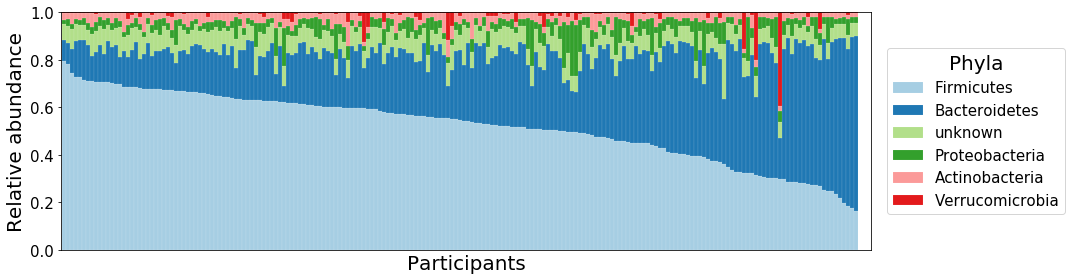

In [32]:
mb_full_phyla = acs_data.filter(regex='k__').copy()
# mb_full_phyla = acs_data[(acs_data['gender'] == 1)].filter(regex='k__').copy()
mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
labels_fontsize = 20
tick_fontsize = 15

mb_full_phyla = mb_full_phyla.loc[bacteria]
mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)

mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)

acs_mb_full_phyla = mb_full_phyla.copy()

mb_full_phyla.iloc[:, :].plot(kind='bar', stacked=True, edgecolor='white', linewidth=0.1,
                               ax=ax, width=1, color=sns.color_palette('Paired', n_colors=mb_full_phyla.shape[1]))
ax.set_xticks([])
ax.set_ylim((0, 1))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Participants', fontsize=labels_fontsize)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
leg = ax.legend(ncol=1, loc='center left' , bbox_to_anchor=(1.01, 0.5),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()

# plt.savefig(os.path.join(figure_dir, '4_supp_stacked_phyla_abundance_small.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figure_dir, '4_supp_stacked_phyla_abundance.png'), dpi=1200, bbox_inches='tight')

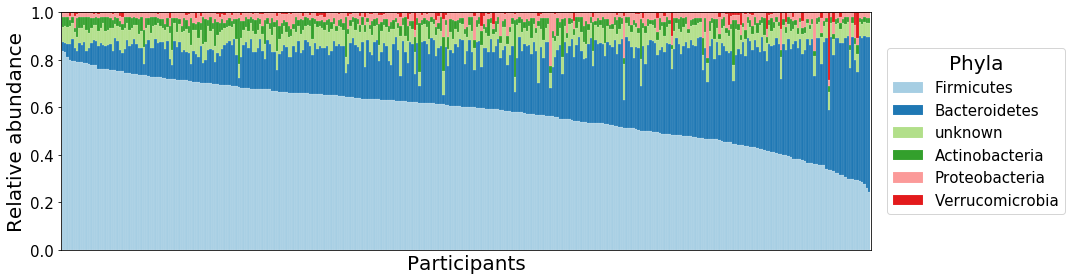

In [33]:
mb_full_phyla = pnp_data[pnp_data['Nextera'] == 'True'].filter(regex='k__').copy()
# mb_full_phyla = pnp_data[(pnp_data['Nextera'] == 'True') & (pnp_data['gender'] == 1)].filter(regex='k__').copy()
mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
labels_fontsize = 20
tick_fontsize = 15

mb_full_phyla = mb_full_phyla.loc[bacteria]
mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)

mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)
pnp_mb_full_phyla = mb_full_phyla.copy()

mb_full_phyla.iloc[:, :].plot(kind='bar', stacked=True, edgecolor='white', linewidth=0.1,
                               ax=ax, width=1, color=sns.color_palette('Paired', n_colors=mb_full_phyla.shape[1]))
ax.set_xticks([])
ax.set_ylim((0, 1))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Participants', fontsize=labels_fontsize)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
leg = ax.legend(ncol=1, loc='center left' , bbox_to_anchor=(1.01, 0.5),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()

# plt.savefig(os.path.join(figure_dir, '4_supp_stacked_phyla_abundance_small.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figure_dir, '4_supp_stacked_phyla_abundance.png'), dpi=1200, bbox_inches='tight')

Firmicutes
(-25894.0, 2.7103883577020056e-06)


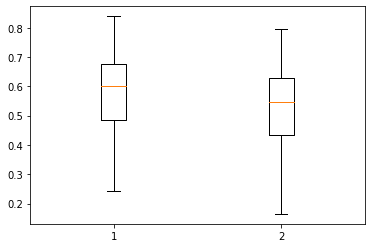

Bacteroidetes
(28758.0, 0.001827724967980004)


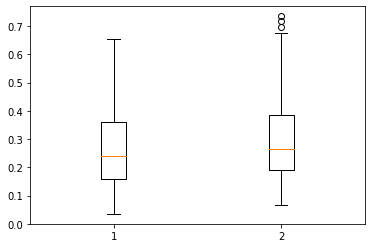

unknown
(29567.0, 0.007286425601318045)


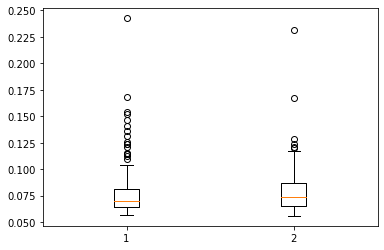

Actinobacteria
(-29111.0, 0.0034239089313716424)


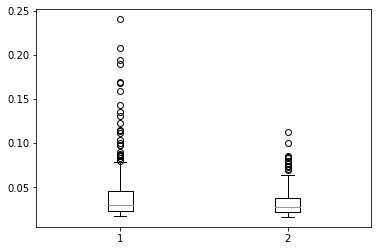

Proteobacteria
(18656.0, 1.7207669249802855e-18)


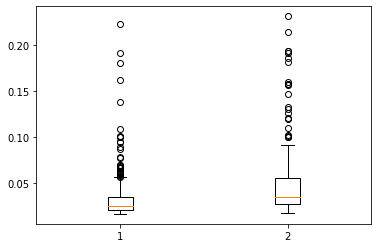

Verrucomicrobia
(30331.5, 0.02249801414825251)


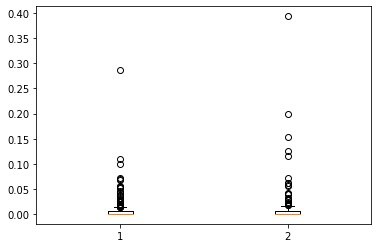

In [34]:
for c in pnp_mb_full_phyla.columns:
    print (c)
    plt.boxplot([pnp_mb_full_phyla[c].values, acs_mb_full_phyla[c].dropna()])
    print (directed_mannwhitneyu(pnp_mb_full_phyla[c], acs_mb_full_phyla[c].dropna()))
    plt.show()

In [20]:
pnp_mb_full_phyla.median()

index
Firmicutes         0.605284
Bacteroidetes      0.251007
unknown            0.070419
Proteobacteria     0.025392
Actinobacteria     0.027351
Verrucomicrobia    0.001344
dtype: float64

In [21]:
acs_mb_full_phyla.median()

index
Firmicutes         0.540880
Bacteroidetes      0.279503
unknown            0.070101
Proteobacteria     0.034797
Actinobacteria     0.027293
Verrucomicrobia    0.001139
dtype: float64

# Plot

## unmatched

### barplot per sample - supp

Text(-0.05, 1.0, 'b')

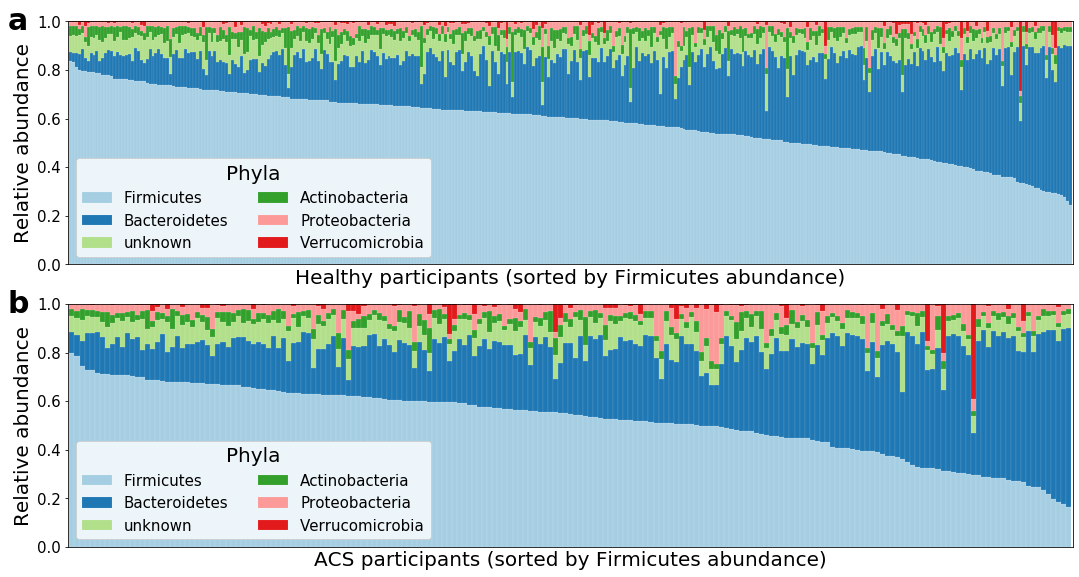

In [43]:
mb_full_phyla = acs_data.filter(regex='k__').copy()
# mb_full_phyla = acs_data[(acs_data['gender'] == 1)].filter(regex='k__').copy()
mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()
mb_full_phyla = mb_full_phyla.loc[bacteria]
mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)
mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)
acs_mb_full_phyla = mb_full_phyla.copy()

mb_full_phyla = pnp_data[pnp_data['Nextera'] == 'True'].filter(regex='k__').copy()
# mb_full_phyla = pnp_data[(pnp_data['Nextera'] == 'True') & (pnp_data['gender'] == 1)].filter(regex='k__').copy()
mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()
mb_full_phyla = mb_full_phyla.loc[bacteria]
mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)
mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)
pnp_mb_full_phyla = mb_full_phyla.copy()

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
labels_fontsize = 20
tick_fontsize = 15

ax = axes[0]
pnp_mb_full_phyla.dropna().iloc[:, :].plot(kind='bar', stacked=True, edgecolor='white', linewidth=0.1,
                               ax=ax, width=1, color=sns.color_palette('Paired', n_colors=pnp_mb_full_phyla.shape[1]))
ax.set_xticks([])
ax.set_ylim((0, 1))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Healthy participants (sorted by Firmicutes abundance)', fontsize=labels_fontsize)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
# leg = ax.legend(ncol=1, loc='center left' , bbox_to_anchor=(1.01, 0.5),
#                   fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
# leg.get_title().set_fontsize(str(labels_fontsize))
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='Phyla', ncol=2)
leg.get_title().set_fontsize(str(labels_fontsize))

ax = axes[1]
acs_mb_full_phyla.dropna().loc[:, pnp_mb_full_phyla.columns].plot(kind='bar', stacked=True, edgecolor='white', linewidth=0.1,
                               ax=ax, width=1, color=sns.color_palette('Paired', n_colors=acs_mb_full_phyla.shape[1]))
ax.set_xticks([])
ax.set_ylim((0, 1))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('ACS participants (sorted by Firmicutes abundance)', fontsize=labels_fontsize)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
# leg = ax.legend(ncol=1, loc='center left' , bbox_to_anchor=(1.01, 0.5),
#                   fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
# leg.get_title().set_fontsize(str(labels_fontsize))
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='Phyla', ncol=2)
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()

plt.text(-0.05, 1., 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.05, 1., 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(curr_dir, 'Supp_taxa_composition_small.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(curr_dir, 'Supp_taxa_composition.png'), dpi=1200, bbox_inches='tight')

In [45]:
pnp_mb_full_phyla.to_csv(os.path.join(curr_dir, 'pnp_mb_full_phyla.csv'))
acs_mb_full_phyla.to_csv(os.path.join(curr_dir, 'acs_mb_full_phyla.csv'))

In [59]:
pd.read_csv(os.path.join(curr_dir, 'pnp_mb_full_phyla.csv')).dropna()
# pd.read_csv(os.path.join(curr_dir, 'acs_mb_full_phyla.csv')).dropna()

,RegistrationCode,Firmicutes,Bacteroidetes,unknown,Actinobacteria,Proteobacteria,Verrucomicrobia
0,714857,0.838930,0.034830,0.066476,0.042156,0.016685,0.000924
1,679153,0.831948,0.038804,0.071982,0.039992,0.016561,0.000713
2,31879,0.813606,0.054925,0.071581,0.039001,0.020159,0.000728
3,300385,0.799721,0.065673,0.076898,0.025448,0.018021,0.014238
4,209749,0.795506,0.091475,0.066363,0.028002,0.017938,0.000717
...,...,...,...,...,...,...,...
335,621285,0.288956,0.610013,0.059664,0.018998,0.021653,0.000717
336,447925,0.286859,0.603574,0.061161,0.019848,0.027849,0.000709
337,515714,0.275607,0.626567,0.058935,0.017811,0.020366,0.000714
338,710879,0.259679,0.637277,0.059459,0.021355,0.021515,0.000715


In [138]:
# pearsonr_rmna(pnp_data.loc[pnp_mb_full_phyla.index, 'gender'], pnp_mb_full_phyla['Actinobacteria'])
# pnp_data.loc[pnp_mb_full_phyla.index, 'gender']

(nan, nan)

### stacked barplots

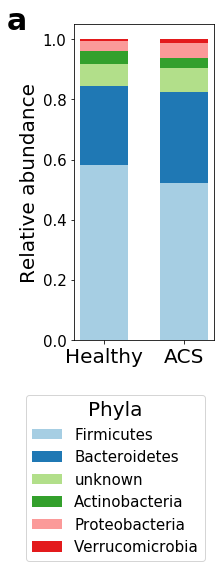

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(3, 8))

labels = ['Healthy', 'ACS']
width=0.6

df_mean = pd.concat((pnp_mb_full_phyla.mean(), acs_mb_full_phyla.mean()), axis=1).sort_values(0, ascending=False)
df_std = pd.concat((pnp_mb_full_phyla.std(), acs_mb_full_phyla.std()), axis=1)

paired_colors = sns.color_palette('Paired', df_mean.shape[0])
for i, color in zip(range(df_mean.shape[0]), paired_colors):
    label = df_mean.index[i]
    if i == 0:
        ax.bar(labels, df_mean.loc[label], width, label=label, color=color) #  yerr=df_std.loc[label]
    else:
        ax.bar(labels, df_mean.loc[label], width, label=label, bottom=df_mean.head(i).sum(), color=color)
ax.tick_params(labelsize=15)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
ax.set_xticklabels(labels, fontsize=20)

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
leg = ax.legend(ncol=1, loc='upper center' , bbox_to_anchor=(0.3, -0.15),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()
plt.text(-0.4, 1.01, 'a', ha='center', va='center', transform=ax.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(curr_dir, 'stacked_barplot_small.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(curr_dir, 'stacked_barplot.png'), dpi=1200, bbox_inches='tight')

Firmicutes
(-25894.0, 2.7103883577020056e-06)


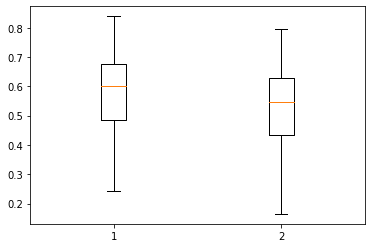

Bacteroidetes
(28758.0, 0.001827724967980004)


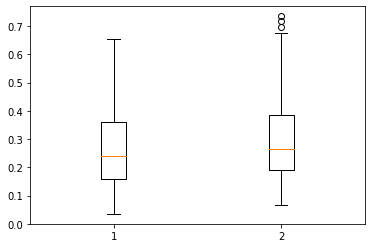

unknown
(29567.0, 0.007286425601318045)


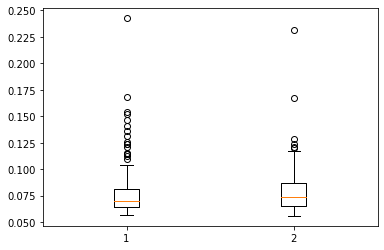

Actinobacteria
(-29111.0, 0.0034239089313716424)


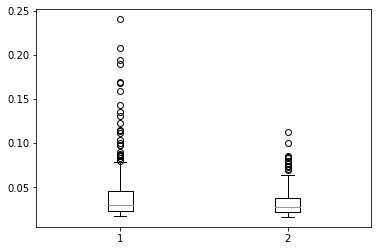

Proteobacteria
(18656.0, 1.7207669249802855e-18)


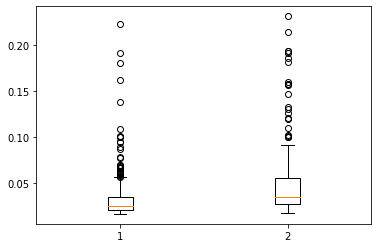

Verrucomicrobia
(30331.5, 0.02249801414825251)


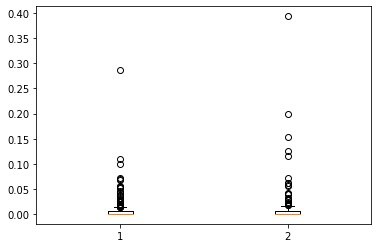

In [47]:
for c in pnp_mb_full_phyla.columns:
    print (c)
    plt.boxplot([pnp_mb_full_phyla[c].values, acs_mb_full_phyla[c].dropna()])
    print (directed_mannwhitneyu(pnp_mb_full_phyla[c], acs_mb_full_phyla[c].dropna()))
    plt.show()

## matched

### barplots per sample

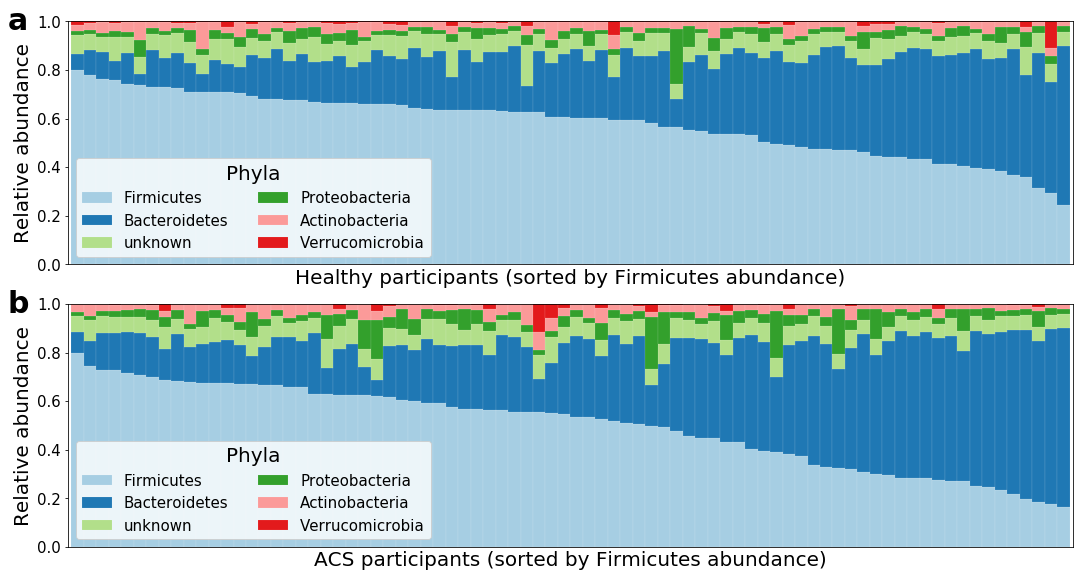

In [48]:
mb_full_phyla = matched_acs_data.filter(regex='k__').copy()
# mb_full_phyla = acs_data[(acs_data['gender'] == 1)].filter(regex='k__').copy()
mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()
mb_full_phyla = mb_full_phyla.loc[bacteria]
mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)
mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)
acs_mb_full_phyla = mb_full_phyla.copy()

mb_full_phyla = matched_pnp_data.filter(regex='k__').copy()
# mb_full_phyla = pnp_data[(pnp_data['Nextera'] == 'True') & (pnp_data['gender'] == 1)].filter(regex='k__').copy()
mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()
mb_full_phyla = mb_full_phyla.loc[bacteria]
mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)
mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)
pnp_mb_full_phyla = mb_full_phyla.copy()

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
labels_fontsize = 20
tick_fontsize = 15

ax = axes[0]
pnp_mb_full_phyla.dropna().iloc[:, :].plot(kind='bar', stacked=True, edgecolor='white', linewidth=0.1,
                               ax=ax, width=1, color=sns.color_palette('Paired', n_colors=pnp_mb_full_phyla.shape[1]))
ax.set_xticks([])
ax.set_ylim((0, 1))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('Healthy participants (sorted by Firmicutes abundance)', fontsize=labels_fontsize)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
# leg = ax.legend(ncol=1, loc='center left' , bbox_to_anchor=(1.01, 0.5),
#                   fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
# leg.get_title().set_fontsize(str(labels_fontsize))
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='Phyla', ncol=2)
leg.get_title().set_fontsize(str(labels_fontsize))

ax = axes[1]
acs_mb_full_phyla.dropna().loc[:, pnp_mb_full_phyla.columns].plot(kind='bar', stacked=True, edgecolor='white', linewidth=0.1,
                               ax=ax, width=1, color=sns.color_palette('Paired', n_colors=acs_mb_full_phyla.shape[1]))
ax.set_xticks([])
ax.set_ylim((0, 1))
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlabel('ACS participants (sorted by Firmicutes abundance)', fontsize=labels_fontsize)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
# leg = ax.legend(ncol=1, loc='center left' , bbox_to_anchor=(1.01, 0.5),
#                   fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
# leg.get_title().set_fontsize(str(labels_fontsize))
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='Phyla', ncol=2)
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()

plt.text(-0.05, 1., 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.05, 1., 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(curr_dir, 'Supp_taxa_composition_matched_small.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(curr_dir, 'Supp_taxa_composition_matched.png'), dpi=1200, bbox_inches='tight')

In [49]:
pnp_mb_full_phyla.to_csv(os.path.join(curr_dir, 'matched_pnp_mb_full_phyla.csv'))
acs_mb_full_phyla.to_csv(os.path.join(curr_dir, 'matched_acs_mb_full_phyla.csv'))

### stacked barplots

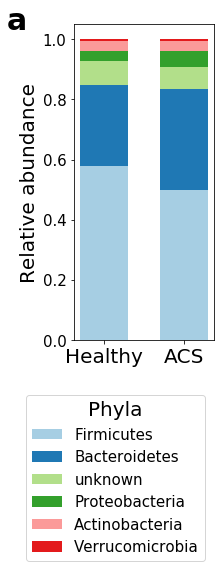

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(3, 8))

labels = ['Healthy', 'ACS']
width=0.6

df_mean = pd.concat((pnp_mb_full_phyla.mean(), acs_mb_full_phyla.mean()), axis=1).sort_values(0, ascending=False)
df_std = pd.concat((pnp_mb_full_phyla.std(), acs_mb_full_phyla.std()), axis=1)

paired_colors = sns.color_palette('Paired', df_mean.shape[0])
for i, color in zip(range(df_mean.shape[0]), paired_colors):
    label = df_mean.index[i]
    if i == 0:
        ax.bar(labels, df_mean.loc[label], width, label=label, color=color) #  yerr=df_std.loc[label]
    else:
        ax.bar(labels, df_mean.loc[label], width, label=label, bottom=df_mean.head(i).sum(), color=color)
ax.tick_params(labelsize=15)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
ax.set_xticklabels(labels, fontsize=20)

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
leg = ax.legend(ncol=1, loc='upper center' , bbox_to_anchor=(0.3, -0.15),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()
plt.text(-0.4, 1.01, 'a', ha='center', va='center', transform=ax.transAxes, fontsize=30, weight = 'bold')

# plt.savefig(os.path.join(curr_dir, 'stacked_barplot_matched_small.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(curr_dir, 'stacked_barplot_matched.png'), dpi=1200, bbox_inches='tight')

Firmicutes
(-2347.0, 0.0018114446158631497)


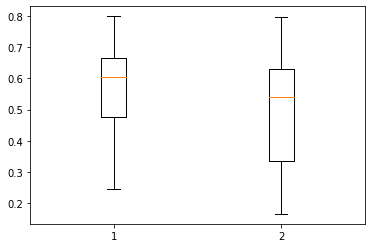

Bacteroidetes
(2624.0, 0.024767263735054685)


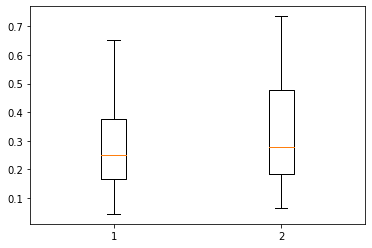

unknown
(-2887.0, 0.14311167639328065)


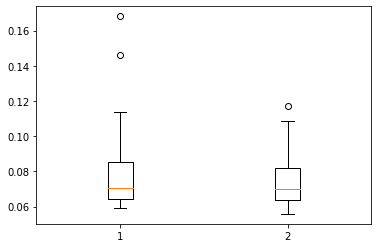

Proteobacteria
(2031.0, 3.336630434001104e-05)


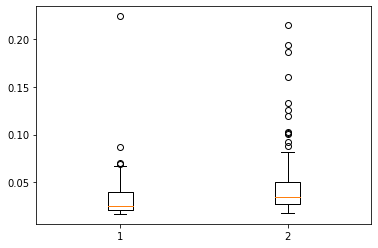

Actinobacteria
(-3012.0, 0.2611298905467677)


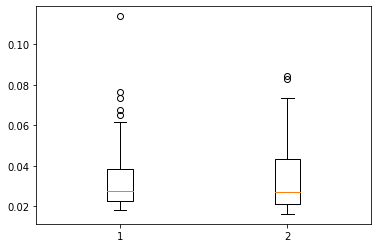

Verrucomicrobia
(3011.0, 0.2600216944951386)


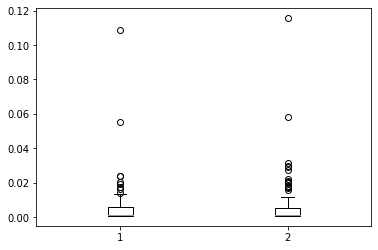

In [51]:
for c in pnp_mb_full_phyla.columns:
    print (c)
    plt.boxplot([pnp_mb_full_phyla[c].values, acs_mb_full_phyla[c].dropna()])
    print (directed_mannwhitneyu(pnp_mb_full_phyla[c], acs_mb_full_phyla[c].dropna()))
    plt.show()

In [55]:
pnp_mb_full_phyla.dropna().shape

(80, 6)

# 4-way stacked bar plots

In [12]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
pnp_data = pnp_data[pnp_data.IsGenotek == 0]
pnp_data = pnp_data[pnp_data.Nextera == 'True']
acs_data['ACS sample'] = 1
pnp_data['ACS sample'] = 0

acs_199 = acs_data['k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii|fSGB__222|gSGB__534|sSGB__714'].dropna().index

data = pd.concat((acs_data, pnp_data), axis=0, sort=False).filter(regex='k__|Age|gender|ACS sample').copy()
print (data.shape)

mb_data = remove_rare_elements(data.filter(regex='k__').dropna(how='all').T, rare_def=0.05, null=False).T
print (mb_data.shape)

data = pd.concat((data.filter(regex='Age|gender|ACS sample'), mb_data), axis=1).dropna(how='any')
print (data.shape)
# data['const'] = 1


matched_samples = pd.read_csv(os.path.join(paper_dir, 'Matching', 'PNP1-ACS_matching', 'PNP1-ACS_microbiome_age+sex+bmi+DM+smoking_1:1.csv'), index_col=0)
matched_pnp_data = data.loc[matched_samples[matched_samples['ACS sample'] == 0].index]
matched_acs_data = data.loc[matched_samples[matched_samples['ACS sample'] == 1].index]
matched_data = data.loc[matched_samples.index].copy()

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(542, 2976)
removing 0.742 of elements.
(539, 768)
(534, 771)


In [14]:
bacteria = ['Verrucomicrobia', 'Actinobacteria', 'Proteobacteria', 'unknown', 'Bacteroidetes', 'Firmicutes']

In [15]:
def compute_taxa_mean(data):
    mb_full_phyla = data.filter(regex='k__').copy()
    # mb_full_phyla = acs_data[(acs_data['gender'] == 1)].filter(regex='k__').copy()
    mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
    mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()
    mb_full_phyla = mb_full_phyla.loc[bacteria]
    mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)
    mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)
    return mb_full_phyla

In [18]:
matched_acs_mb_full_phyla = compute_taxa_mean(matched_acs_data.filter(regex='k__').copy())
matched_pnp_mb_full_phyla = compute_taxa_mean(matched_pnp_data.filter(regex='k__').copy())
acs_mb_full_phyla = compute_taxa_mean(data[data['ACS sample']==1].filter(regex='k__').copy())
pnp_mb_full_phyla = compute_taxa_mean(data[data['ACS sample']==0].filter(regex='k__').copy())

In [66]:
matched_acs_mb_full_phyla.to_csv(os.path.join(curr_dir, 'matched_acs_mb_full_phyla.csv'))
matched_pnp_mb_full_phyla.to_csv(os.path.join(curr_dir, 'matched_pnp_mb_full_phyla.csv'))
acs_mb_full_phyla.to_csv(os.path.join(curr_dir, 'acs_mb_full_phyla.csv'))
pnp_mb_full_phyla.to_csv(os.path.join(curr_dir, 'pnp_mb_full_phyla.csv'))

Firmicutes
(-1542.0, 0.007998130290717467)


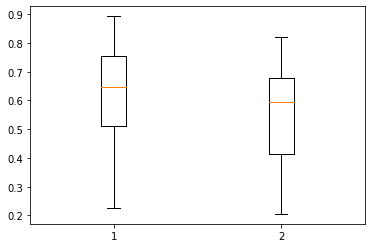

Bacteroidetes
(1733.0, 0.0669660046424479)


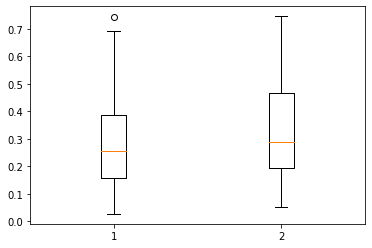

Proteobacteria
(1404.0, 0.0010823574281896681)


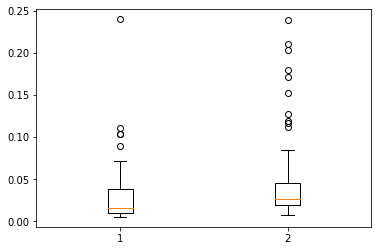

unknown
(1908.0, 0.2530897054780036)


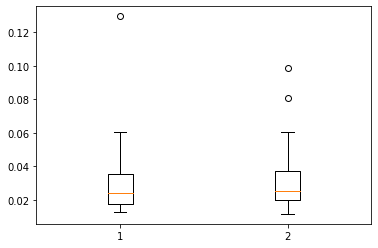

Actinobacteria
(1839.0, 0.16020310010962463)


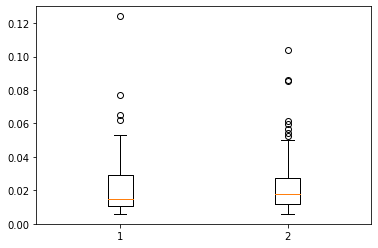

Verrucomicrobia
(1796.0, 0.11535275891292479)


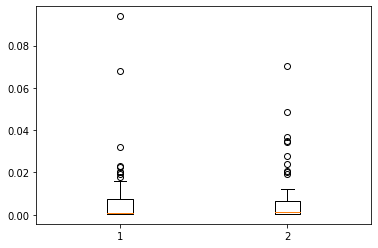

In [28]:
for c in matched_acs_mb_full_phyla.columns:
    print (c)
    plt.boxplot([matched_pnp_mb_full_phyla[c].values, matched_acs_mb_full_phyla[c].dropna()])
    print (directed_mannwhitneyu(matched_pnp_mb_full_phyla[c], matched_acs_mb_full_phyla[c].dropna()))
    plt.show()
# #     
# matched_acs_mb_full_phyla

Firmicutes
(-25777.0, 5.872421818713566e-06)


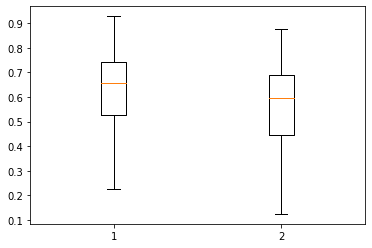

Bacteroidetes
(28541.0, 0.0027261965919781273)


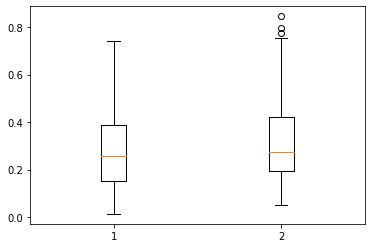

Proteobacteria
(19123.0, 8.473564716468747e-17)


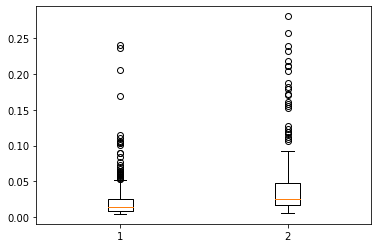

unknown
(28105.0, 0.0012150305615165296)


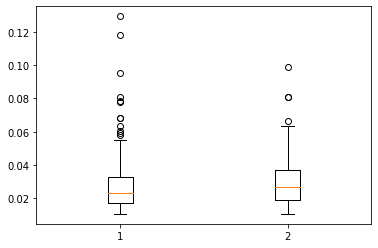

Actinobacteria
(-29220.0, 0.00853579906040663)


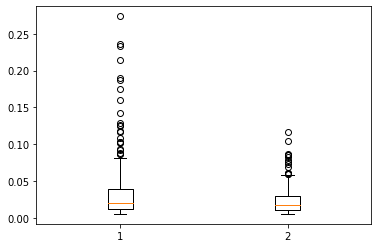

Verrucomicrobia
(30438.0, 0.04660894616286337)


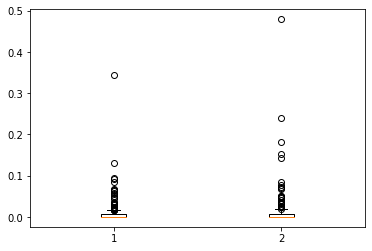

In [29]:
for c in acs_mb_full_phyla.columns:
    print (c)
    plt.boxplot([pnp_mb_full_phyla[c].values, acs_mb_full_phyla[c].dropna()])
    print (directed_mannwhitneyu(pnp_mb_full_phyla[c], acs_mb_full_phyla[c].dropna()))
    plt.show()
# #     
# matched_acs_mb_full_phyla

In [65]:
from scipy.stats import kruskal
pnp_mb_full_phyla.shape

(335, 6)

In [61]:
for phylum in bacteria:
    t, p  = kruskal(pnp_mb_full_phyla.loc[:, phylum], acs_mb_full_phyla.loc[:, phylum])
    print (phylum, p)
    t, p  = kruskal(matched_pnp_mb_full_phyla.loc[:, phylum], matched_acs_mb_full_phyla.loc[:, phylum])
    print (phylum, p)
    
    

Verrucomicrobia 0.09316135068120913
Verrucomicrobia 0.22977981402188252
Actinobacteria 0.017058143409196133
Actinobacteria 0.3192470902443482
Proteobacteria 1.690608882111303e-16
Proteobacteria 0.0021475234476868847
unknown 0.0024277273770866425
unknown 0.5046563693176223
Bacteroidetes 0.005447527010521832
Bacteroidetes 0.13331475149449282
Firmicutes 1.172921440013394e-05
Firmicutes 0.015892121860562002


Text(-0.25, 1, 'a')

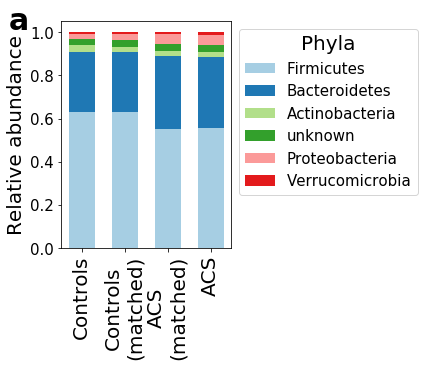

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
labels_fontsize = 20
tick_fontsize = 15

labels = ['Controls', 'Controls\n(matched)', 'ACS\n(matched)', 'ACS']
width=0.6

df_mean = pd.concat((pnp_mb_full_phyla.mean(), matched_pnp_mb_full_phyla.mean(), matched_acs_mb_full_phyla.mean(), acs_mb_full_phyla.mean()), axis=1).sort_values(0, ascending=False)
df_std = pd.concat((pnp_mb_full_phyla.std(), matched_pnp_mb_full_phyla.std(), matched_acs_mb_full_phyla.std(), acs_mb_full_phyla.std()), axis=1)

paired_colors = sns.color_palette('Paired', df_mean.shape[0])
for i, color in zip(range(df_mean.shape[0]), paired_colors):
    label = df_mean.index[i]
    if i == 0:
        ax.bar(labels, df_mean.loc[label], width, label=label, color=color) #  yerr=df_std.loc[label]
    else:
        ax.bar(labels, df_mean.loc[label], width, label=label, bottom=df_mean.head(i).sum(), color=color)
ax.tick_params(labelsize=15)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
ax.set_xticklabels(labels, fontsize=20, rotation=90)

leg = ax.legend(ncol=1, loc='upper left' , bbox_to_anchor=(1, 1),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()
plt.text(-0.25, 1, 'a', ha='center', va='center', transform=ax.transAxes, fontsize=30, weight = 'bold')

# plt.savefig(os.path.join(curr_dir, 'stacked_barplot_matched_small.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(curr_dir, 'stacked_barplot_matched.png'), dpi=1200, bbox_inches='tight')

In [54]:
required_data_for_plot = {'df_mean':df_mean, 'df_std':df_mean}
with open(os.path.join(curr_dir, 'required_data_for_plot.pkl'), 'wb') as handle:
    pickle.dump(required_data_for_plot, handle)